## Pretrained VisualBERT with ViT and BERT on evaluating the test labels


### Load the datasets, dataset cleaning and filtering
###### Data labelling for train and val dataset, load BERT and ViT
###### Obtain the vit features
###### Handling dimension issue
###### Fuse both text and visual features
###### text embeddings and the projected visual features are fed into a VisualBERT model
###### Obtain the predictions for test dataset
###### Save the best models

In [ ]:
#!/usr/bin/env python3
"""
OPTIMIZED BERT MULTILINGUAL + VIT + PRE-TRAINED VISUALBERT
================================================================
With pre-trained VisualBERT for cross-modal fusion
"""

import os
import gc
import pickle
import hashlib
import subprocess
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Auto-install packages
def install_package(package):
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", package, "--break-system-packages"],
                      check=True, capture_output=True)
        print(f"Installed {package}")
    except:
        print(f"Failed to install {package}")

# Install required packages
required_packages = ["torch", "torchvision", "transformers", "pillow", "requests"]
for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
    except ImportError:
        install_package(package)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, VisualBertModel, VisualBertConfig

# OPTIMIZED Configuration with VisualBERT
class OptimizedConfig:
    NUM_CLASSES = 2
    MAX_TEXT_LENGTH = 128
    BATCH_SIZE = 8
    NUM_EPOCHS = 15  # More epochs with better early stopping

    # Learning rate scheduling
    LEARNING_RATE = 5e-6  # Starting learning rate
    WARMUP_STEPS = 100   # Linear warmup steps
    MAX_LEARNING_RATE = 2e-5  # Peak learning rate
    MIN_LEARNING_RATE = 1e-7  # Minimum learning rate

    BERT_MODEL = "bert-base-multilingual-cased"
    VIT_MODEL = "google/vit-base-patch16-224-in21k"
    VISUALBERT_MODEL = "uclanlp/visualbert-vqa-coco-pre"  # Pre-trained VisualBERT
    HIDDEN_SIZE = 768
    VISUAL_DIM = 2048  # VisualBERT visual feature dimension

    # BALANCED bias correction (not extreme)
    USE_WEIGHTED_SAMPLER = True
    ADAPTIVE_THRESHOLD = True
    FORCE_BALANCE_RATIO = 0.25
    PREDICTION_THRESHOLD = 0.1

    # Enhanced regularization
    DROPOUT_RATE = 0.5  # Higher dropout as recommended
    WEIGHT_DECAY = 0.02
    GRADIENT_CLIP_NORM = 1.0

    # F1-based early stopping
    EARLY_STOPPING_PATIENCE = 4
    EARLY_STOPPING_METRIC = 'f1_macro'  # Use F1-macro instead of loss
    MIN_DELTA = 0.001

config = OptimizedConfig()

def mount_drive():
    """Mount Google Drive if in Colab"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Drive mounted successfully!")
        return True
    except:
        print("Not in Colab environment")
        return False

class AdvancedFeatureCache:
    """Advanced caching system with hash-based versioning"""

    def __init__(self, cache_dir="feature_cache"):
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

    def _get_hash(self, data):
        """Generate hash for data versioning"""
        if isinstance(data, pd.DataFrame):
            return hashlib.md5(str(data.values.tobytes()).encode()).hexdigest()[:8]
        return hashlib.md5(str(data).encode()).hexdigest()[:8]

    def get_cache_path(self, feature_type, data_hash):
        return os.path.join(self.cache_dir, f"{feature_type}_{data_hash}.pkl")

    def load(self, feature_type, data_hash):
        cache_path = self.get_cache_path(feature_type, data_hash)
        if os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    features = pickle.load(f)
                print(f"Loaded {feature_type} features from cache: {features.shape}")
                return features
            except Exception as e:
                print(f"Cache loading failed: {e}")
        return None

    def save(self, features, feature_type, data_hash):
        cache_path = self.get_cache_path(feature_type, data_hash)
        try:
            with open(cache_path, 'wb') as f:
                pickle.dump(features, f)
            print(f"Cached {feature_type} features: {features.shape}")
        except Exception as e:
            print(f"Caching failed: {e}")

def load_and_process_data():
    """Load data with optimized processing"""
    print("Loading and processing datasets...")

    is_colab = mount_drive()

    if is_colab:
        train_path = "/content/drive/MyDrive/Memotion3/train.csv"
        val_path = "/content/drive/MyDrive/Memotion3/val.csv"
        test_path = "/content/drive/MyDrive/Memotion3/test_with_labels.csv"
    else:
        train_path = "train.csv"
        val_path = "val.csv"
        test_path = "test_with_labels.csv"

    def process_dataset(path, name, sample_size):
        try:
            if 'val' in name.lower():
                df = pd.read_csv(path, delimiter='\t')
            else:
                try:
                    df = pd.read_csv(path, delimiter=',')
                except:
                    df = pd.read_csv(path, delimiter='\t')

            print(f"Loaded {name}: {len(df)} samples")

            if 'Unnamed: 0' in df.columns:
                df['id'] = df['Unnamed: 0']
            elif 'id' not in df.columns:
                df['id'] = range(len(df))

            if 'offensive' in df.columns:
                hate_categories = ['offensive', 'very_offensive', 'slight', 'hateful_offensive']
                df['label'] = df['offensive'].apply(lambda x: 1 if x in hate_categories else 0)
            elif 'label' not in df.columns:
                df['label'] = 0

            if 'image_url' not in df.columns:
                df['image_url'] = 'placeholder.jpg'
            if 'ocr' not in df.columns:
                df['ocr'] = 'placeholder text'

            df = df[['id', 'image_url', 'ocr', 'label']].copy()

            if sample_size and len(df) > sample_size:
                df = df.head(sample_size).copy()

            # Optimized text cleaning
            df['ocr'] = df['ocr'].astype(str).str[:300]
            df = df[df['ocr'].str.split().str.len() >= 2]
            df = df[df['ocr'].str.split().str.len() <= 50]
            df = df.drop_duplicates(subset=['ocr'], keep='first')

            print(f"After processing {name}: {len(df)} samples")
            print(f"Label distribution: {dict(df['label'].value_counts())}")

            return df

        except Exception as e:
            print(f"Error loading {name}: {e}")
            return pd.DataFrame()

    train_df = process_dataset(train_path, "Train", 4000)
    val_df = process_dataset(val_path, "Validation", 1000)
    test_df = process_dataset(test_path, "Test", 1000)

    return train_df, val_df, test_df

def create_vit_features(df, cache=None):
    """Create REAL ViT features with memory management and caching"""
    if cache:
        data_hash = cache._get_hash(df)
        cached_features = cache.load("vit", data_hash)
        if cached_features is not None:
            return cached_features

    num_samples = len(df)

    # Try to use REAL ViT with memory management
    try:
        import torch
        from PIL import Image
        import requests
        from io import BytesIO
        from transformers import ViTModel, ViTFeatureExtractor

        device = "cuda" if torch.cuda.is_available() else "cpu"

        print("Loading ViT model for REAL feature extraction...")
        torch.cuda.empty_cache() if device == "cuda" else None

        feature_extractor = ViTFeatureExtractor.from_pretrained(config.VIT_MODEL)
        vit_model = ViTModel.from_pretrained(config.VIT_MODEL, torch_dtype=torch.float16)
        vit_model = vit_model.half().to(device)
        vit_model.eval()

        vit_features = []
        successful_extractions = 0

        # Process in chunks to manage memory - increase to 200 for better coverage
        max_samples = min(5000, num_samples)
        print(f"Extracting REAL ViT features for {max_samples} samples...")

        for i, (idx, row) in enumerate(df.head(max_samples).iterrows()):
            try:
                image_url = row.get('image_url', '')
                if image_url and image_url != 'placeholder.jpg' and 'http' in str(image_url):
                    # Download and process image
                    response = requests.get(image_url, timeout=8, headers={'User-Agent': 'Mozilla/5.0'})
                    if response.status_code == 200:
                        image = Image.open(BytesIO(response.content)).convert('RGB')
                        inputs = feature_extractor(images=image, return_tensors="pt")

                        # Move to GPU and extract features
                        inputs = {k: v.to(device) for k, v in inputs.items()}

                        with torch.no_grad():
                            outputs = vit_model(**inputs)
                            features = outputs.pooler_output.squeeze(0)
                            vit_features.append(features.cpu().numpy())
                            successful_extractions += 1

                        # Clear GPU memory after each image
                        torch.cuda.empty_cache() if device == "cuda" else None
                    else:
                        # Fallback for failed downloads
                        vit_features.append(np.zeros(config.HIDDEN_SIZE, dtype=np.float32))
                else:
                    # Fallback for missing URLs
                    vit_features.append(np.zeros(config.HIDDEN_SIZE, dtype=np.float32))

            except Exception as e:
                # Fallback for any extraction errors
                vit_features.append(np.zeros(config.HIDDEN_SIZE, dtype=np.float32))

            # Progress update and memory cleanup
            if (i + 1) % 25 == 0:
                print(f"Processed {i + 1}/{max_samples} images ({successful_extractions} successful)")
                torch.cuda.empty_cache() if device == "cuda" else None

        # Extend features to all samples
        if len(vit_features) > 0:
            # Use last successful feature for remaining samples (better than random)
            last_real_feature = None
            for feat in reversed(vit_features):
                if not np.allclose(feat, 0):  # Find last non-zero feature
                    last_real_feature = feat
                    break

            if last_real_feature is None:
                last_real_feature = np.random.randn(config.HIDDEN_SIZE).astype(np.float32)
                last_real_feature = last_real_feature / (np.linalg.norm(last_real_feature) + 1e-8)

            # Fill remaining samples
            while len(vit_features) < num_samples:
                # Add slight noise to avoid identical features
                noisy_feature = last_real_feature + np.random.normal(0, 0.01, last_real_feature.shape)
                noisy_feature = noisy_feature / (np.linalg.norm(noisy_feature) + 1e-8)
                vit_features.append(noisy_feature.astype(np.float32))
        else:
            # All failed, use normalized random features
            vit_features = [np.random.randn(config.HIDDEN_SIZE).astype(np.float32) for _ in range(num_samples)]
            for i in range(len(vit_features)):
                vit_features[i] = vit_features[i] / (np.linalg.norm(vit_features[i]) + 1e-8)

        vit_features = np.array(vit_features, dtype=np.float32)
        print(f"ViT features created: {vit_features.shape} ({successful_extractions}/{max_samples} real extractions)")

        # Save to cache
        if cache:
            cache.save(vit_features, "vit", data_hash)

        return vit_features

    except Exception as e:
        print(f"REAL ViT extraction failed: {e}")
        print("Falling back to normalized dummy features...")

        # Fallback to dummy features
        features = np.random.randn(num_samples, config.HIDDEN_SIZE).astype(np.float32)
        features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-8)

        if cache:
            cache.save(features, "vit", data_hash)

        print(f"Dummy ViT features created: {features.shape}")
        return features

def create_visualbert_compatible_features(vit_features):
    """
    Create VisualBERT-compatible visual features from ViT features
    ViT: 768-dim → VisualBERT: 2048-dim
    """
    num_samples = vit_features.shape[0]

    # Create 2048-dim features from ViT features (768-dim)
    visual_features = np.zeros((num_samples, config.VISUAL_DIM), dtype=np.float32)

    # Method: Intelligently expand ViT features
    # Repeat ViT features to fill 2048 dimensions
    vit_repeats = config.VISUAL_DIM // config.HIDDEN_SIZE  # 2048 // 768 = 2
    remaining_dims = config.VISUAL_DIM % config.HIDDEN_SIZE  # 2048 % 768 = 512

    # Fill with repeated ViT features
    for i in range(vit_repeats):
        start_idx = i * config.HIDDEN_SIZE
        end_idx = (i + 1) * config.HIDDEN_SIZE

        if i == 0:
            # First copy: original ViT features
            visual_features[:, start_idx:end_idx] = vit_features
        else:
            # Second copy: add small variations
            noise_factor = 0.05
            noise = np.random.normal(0, noise_factor, vit_features.shape).astype(np.float32)
            visual_features[:, start_idx:end_idx] = vit_features + noise

    # Fill remaining dimensions with statistical features
    if remaining_dims > 0:
        # Use statistical features of ViT as additional dimensions
        vit_mean = np.mean(vit_features, axis=1, keepdims=True)
        vit_std = np.std(vit_features, axis=1, keepdims=True)
        vit_max = np.max(vit_features, axis=1, keepdims=True)
        vit_min = np.min(vit_features, axis=1, keepdims=True)

        # Create additional features
        additional_features = np.concatenate([vit_mean, vit_std, vit_max, vit_min], axis=1)
        # Repeat to fill remaining dimensions
        repetitions = remaining_dims // additional_features.shape[1] + 1
        extended_features = np.tile(additional_features, (1, repetitions))[:, :remaining_dims]

        visual_features[:, -remaining_dims:] = extended_features

    # Normalize the features
    visual_features = visual_features / (np.linalg.norm(visual_features, axis=1, keepdims=True) + 1e-8)

    print(f"Created VisualBERT-compatible features from ViT: {visual_features.shape}")
    return visual_features

class HateSpeechDataset(Dataset):
    """Dataset for hate speech detection with VisualBERT support"""

    def __init__(self, df, vit_features, visual_features, tokenizer, bert_tokenizer):
        self.texts = df['ocr'].tolist()
        self.labels = df['label'].tolist()
        self.vit_features = vit_features
        self.visual_features = visual_features
        self.tokenizer = tokenizer
        self.bert_tokenizer = bert_tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # BERT tokenization for main model
        encoding = self.tokenizer(
            text,
            max_length=config.MAX_TEXT_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # BERT tokenization for VisualBERT (same tokenizer, but separate for clarity)
        bert_encoding = self.bert_tokenizer(
            text,
            max_length=config.MAX_TEXT_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'bert_input_ids': bert_encoding['input_ids'].squeeze(0),
            'bert_attention_mask': bert_encoding['attention_mask'].squeeze(0),
            'vit_features': torch.FloatTensor(self.vit_features[idx]),
            'visual_features': torch.FloatTensor(self.visual_features[idx]),
            'labels': torch.LongTensor([label])
        }

class OptimizedBertViTVisualBertModel(nn.Module):
    """
    OPTIMIZED model with pre-trained VisualBERT:
    - BERT Multilingual for text
    - ViT for visual features
    - Pre-trained VisualBERT for cross-modal fusion
    - Enhanced regularization
    """

    def __init__(self):
        super().__init__()

        # BERT Multilingual with differential learning rates
        self.bert_model = BertModel.from_pretrained(config.BERT_MODEL)

        # Gradual unfreezing with differential LR
        for param in self.bert_model.embeddings.parameters():
            param.requires_grad = False
        for layer in self.bert_model.encoder.layer[:-4]:  # Unfreeze last 4 layers
            for param in layer.parameters():
                param.requires_grad = False

        # Pre-trained VisualBERT initialization
        try:
            print(f"Loading pre-trained VisualBERT: {config.VISUALBERT_MODEL}")
            self.visual_bert = VisualBertModel.from_pretrained(config.VISUALBERT_MODEL)

            # Freeze most of VisualBERT except last few layers
            for param in self.visual_bert.embeddings.parameters():
                param.requires_grad = False
            for layer in self.visual_bert.encoder.layer[:-2]:  # Only train last 2 layers
                for param in layer.parameters():
                    param.requires_grad = False

            self.use_visualbert = True
            print("Pre-trained VisualBERT loaded successfully")

            # Get visual embedding dimension from VisualBERT config
            if hasattr(self.visual_bert.config, 'visual_embedding_dim'):
                self.visual_embedding_dim = self.visual_bert.config.visual_embedding_dim
            else:
                self.visual_embedding_dim = 2048  # Standard VisualBERT dimension

        except Exception as e:
            print(f"Failed to load pre-trained VisualBERT: {e}")
            self.visual_bert = None
            self.use_visualbert = False
            self.visual_embedding_dim = config.VISUAL_DIM

        # Visual feature projection for VisualBERT
        if self.use_visualbert:
            self.visual_feature_proj = nn.Linear(config.VISUAL_DIM, self.visual_embedding_dim)

        # ViT projection for fusion
        self.vit_projection = nn.Sequential(
            nn.Linear(config.HIDDEN_SIZE, config.HIDDEN_SIZE),
            nn.LayerNorm(config.HIDDEN_SIZE),
            nn.Dropout(config.DROPOUT_RATE * 0.3)
        )

        # Final fusion layer
        if self.use_visualbert:
            # VisualBERT output + ViT features
            fusion_dim = config.HIDDEN_SIZE * 2
        else:
            # Fallback: BERT + ViT
            fusion_dim = config.HIDDEN_SIZE * 2
            self.text_projection = nn.Sequential(
                nn.Linear(config.HIDDEN_SIZE, config.HIDDEN_SIZE),
                nn.LayerNorm(config.HIDDEN_SIZE),
                nn.Dropout(config.DROPOUT_RATE * 0.3)
            )

        # Simplified classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(config.DROPOUT_RATE),
            nn.Linear(fusion_dim, config.NUM_CLASSES)
        )

    def forward(self, input_ids, attention_mask, bert_input_ids, bert_attention_mask, vit_features, visual_features, labels=None):

        # Process ViT features
        vit_projected = self.vit_projection(vit_features)

        if self.use_visualbert and self.visual_bert is not None:
            try:
                batch_size = bert_input_ids.size(0)

                # Project visual features to VisualBERT dimension
                visual_embeds = self.visual_feature_proj(visual_features)
                visual_embeds = visual_embeds.unsqueeze(1)  # (batch_size, 1, visual_dim)

                # Create visual attention mask
                visual_attention_mask = torch.ones(
                    batch_size, 1,
                    device=bert_input_ids.device,
                    dtype=bert_attention_mask.dtype
                )

                # Ensure BERT tokens are in valid range
                vocab_size = self.visual_bert.config.vocab_size
                bert_input_ids_safe = torch.clamp(bert_input_ids, 0, vocab_size - 1)

                # VisualBERT forward pass
                visualbert_outputs = self.visual_bert(
                    input_ids=bert_input_ids_safe,
                    attention_mask=bert_attention_mask,
                    visual_embeds=visual_embeds,
                    visual_attention_mask=visual_attention_mask,
                    return_dict=True
                )

                # Get VisualBERT pooled output
                text_visual_combined = visualbert_outputs.pooler_output

            except Exception as e:
                print(f"VisualBERT forward failed: {e}, using fallback")
                # Fallback to BERT + simple projection
                bert_outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
                text_pooled = bert_outputs.pooler_output
                text_projected = self.text_projection(text_pooled)
                text_visual_combined = text_projected + vit_projected
        else:
            # Fallback: BERT + ViT fusion
            bert_outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            text_pooled = bert_outputs.pooler_output
            text_projected = self.text_projection(text_pooled)
            text_visual_combined = text_projected + vit_projected

        # Final fusion: VisualBERT/BERT output + ViT features
        final_features = torch.cat([text_visual_combined, vit_projected], dim=-1)

        # Classification
        logits = self.classifier(final_features)

        outputs = {'logits': logits}

        if labels is not None:
            # Moderate class weights (not extreme)
            class_weights = torch.tensor([2.0, 3.0], device=logits.device, dtype=torch.float32)
            loss_fn = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
            loss = loss_fn(logits, labels.squeeze(-1))
            outputs['loss'] = loss

        return outputs

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Linear warmup + decay scheduler"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

class F1EarlyStopping:
    """F1-macro early stopping for imbalanced data"""
    def __init__(self, patience=4, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_f1 = -float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_f1, model):
        if val_f1 > self.best_f1 + self.min_delta:
            self.best_f1 = val_f1
            self.counter = 0
            self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        return False

def get_adaptive_threshold(probs, target_ratio=0.25):
    """Calculate adaptive threshold for target positive ratio"""
    if len(probs) == 0:
        return config.PREDICTION_THRESHOLD

    sorted_probs = np.sort(probs)[::-1]
    target_count = int(len(probs) * target_ratio)

    if target_count == 0:
        return 0.99
    elif target_count >= len(probs):
        return 0.01
    else:
        threshold = sorted_probs[target_count - 1]
        return max(0.05, min(0.95, threshold))

def force_balanced_predictions(probs, target_ratio=0.25):
    """Force balanced predictions using adaptive thresholding"""
    probs_np = np.array(probs)

    adaptive_threshold = get_adaptive_threshold(probs_np, target_ratio)
    adaptive_preds = (probs_np > adaptive_threshold).astype(int)

    num_samples = len(probs_np)
    target_positives = max(1, int(num_samples * target_ratio))
    top_k_indices = np.argpartition(probs_np, -target_positives)[-target_positives:]
    topk_preds = np.zeros(num_samples, dtype=int)
    topk_preds[top_k_indices] = 1

    adaptive_ratio = adaptive_preds.mean()
    topk_ratio = topk_preds.mean()

    if abs(adaptive_ratio - target_ratio) <= abs(topk_ratio - target_ratio):
        final_preds = adaptive_preds
        method = "adaptive"
        final_ratio = adaptive_ratio
    else:
        final_preds = topk_preds
        method = "top-k"
        final_ratio = topk_ratio

    print(f"Balanced predictions: {method}, ratio: {final_ratio:.3f}, threshold: {adaptive_threshold:.3f}")
    return final_preds

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Optimized training epoch with learning rate scheduling"""
    model.train()
    total_loss = 0
    all_labels = []
    all_probs = []

    for batch in tqdm(dataloader, desc="Training"):
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            bert_input_ids = batch['bert_input_ids'].to(device)
            bert_attention_mask = batch['bert_attention_mask'].to(device)
            vit_features = batch['vit_features'].to(device)
            visual_features = batch['visual_features'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask, bert_input_ids, bert_attention_mask,
                          vit_features, visual_features, labels)
            loss = outputs['loss']

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.GRADIENT_CLIP_NORM)
            optimizer.step()

            # Step scheduler per batch for warmup
            if scheduler:
                scheduler.step()

            probs = torch.softmax(outputs['logits'], dim=-1)
            all_labels.extend(labels.squeeze(-1).detach().cpu().numpy())
            all_probs.extend(probs[:, 1].detach().cpu().numpy())

            total_loss += loss.item()

        except Exception as e:
            print(f"Batch error: {e}")
            continue

    # Calculate training metrics
    if all_probs:
        balanced_preds = force_balanced_predictions(all_probs, config.FORCE_BALANCE_RATIO)
        train_acc = accuracy_score(all_labels, balanced_preds)

        try:
            train_auc = roc_auc_score(all_labels, all_probs)
        except:
            train_auc = 0.5
    else:
        train_acc = 0.0
        train_auc = 0.5

    return total_loss / len(dataloader), train_acc, train_auc

def evaluate_model(model, dataloader, device, return_loss=False):
    """Evaluate with comprehensive metrics including validation loss"""
    model.eval()
    all_labels = []
    all_probs = []
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                bert_input_ids = batch['bert_input_ids'].to(device)
                bert_attention_mask = batch['bert_attention_mask'].to(device)
                vit_features = batch['vit_features'].to(device)
                visual_features = batch['visual_features'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, bert_input_ids, bert_attention_mask,
                              vit_features, visual_features, labels)
                probs = torch.softmax(outputs['logits'], dim=-1)

                # Track validation loss
                if return_loss and 'loss' in outputs:
                    total_loss += outputs['loss'].item()
                    num_batches += 1

                all_labels.extend(labels.squeeze(-1).detach().cpu().numpy())
                all_probs.extend(probs[:, 1].detach().cpu().numpy())

            except Exception as e:
                continue

    if not all_labels:
        if return_loss:
            return 0.0, 0.5, 0.0, [], [], [], 0.0
        else:
            return 0.0, 0.5, 0.0, [], [], []

    # Force balanced predictions
    balanced_preds = force_balanced_predictions(all_probs, config.FORCE_BALANCE_RATIO)

    accuracy = accuracy_score(all_labels, balanced_preds)

    # Calculate F1-macro for early stopping
    f1_macro = f1_score(all_labels, balanced_preds, average='macro', zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.5

    if return_loss:
        avg_loss = total_loss / max(num_batches, 1)
        return accuracy, auc, f1_macro, all_labels, balanced_preds, all_probs, avg_loss
    else:
        return accuracy, auc, f1_macro, all_labels, balanced_preds, all_probs

def calculate_detailed_metrics(y_true, y_pred, y_prob):
    """Calculate comprehensive metrics including weighted averages"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_0': precision_score(y_true, y_pred, pos_label=0, zero_division=0),
        'precision_1': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        'recall_0': recall_score(y_true, y_pred, pos_label=0, zero_division=0),
        'recall_1': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        'f1_0': f1_score(y_true, y_pred, pos_label=0, zero_division=0),
        'f1_1': f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

    try:
        metrics['auc'] = roc_auc_score(y_true, y_prob)
    except:
        metrics['auc'] = 0.5

    return metrics

def main():
    """Main training function with optimized VisualBERT approach"""
    print("=" * 70)
    print("OPTIMIZED BERT + VIT + PRE-TRAINED VISUALBERT MODEL")
    print("=" * 70)
    print(f"Target hate speech ratio: {config.FORCE_BALANCE_RATIO*100:.0f}%")
    print(f"WeightedRandomSampler: {config.USE_WEIGHTED_SAMPLER}")
    print(f"Early stopping metric: {config.EARLY_STOPPING_METRIC}")
    print(f"Learning rate schedule: Warmup + Decay")
    print(f"VisualBERT model: {config.VISUALBERT_MODEL}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Load data
    train_df, val_df, test_df = load_and_process_data()

    if train_df.empty:
        print("ERROR: No training data!")
        return

    # Feature extraction
    cache = AdvancedFeatureCache()

    print("\nExtracting ViT features...")
    train_vit = create_vit_features(train_df, cache)
    val_vit = create_vit_features(val_df, cache) if not val_df.empty else np.array([])
    test_vit = create_vit_features(test_df, cache) if not test_df.empty else np.array([])

    print("\nCreating VisualBERT-compatible visual features...")
    train_visual = create_visualbert_compatible_features(train_vit)
    val_visual = create_visualbert_compatible_features(val_vit) if not val_df.empty else np.array([])
    test_visual = create_visualbert_compatible_features(test_vit) if not test_df.empty else np.array([])

    # Initialize optimized model with VisualBERT
    print("\nInitializing OPTIMIZED BERT + ViT + VisualBERT model...")
    tokenizer = BertTokenizer.from_pretrained(config.BERT_MODEL)
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # For VisualBERT compatibility

    model = OptimizedBertViTVisualBertModel()
    model = model.to(device)

    # WeightedRandomSampler
    train_dataset = HateSpeechDataset(train_df, train_vit, train_visual, tokenizer, bert_tokenizer)

    if config.USE_WEIGHTED_SAMPLER:
        # Calculate sample weights for balanced batches
        labels = train_df['label'].values
        class_counts = np.bincount(labels)

        # Inverse frequency weights
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[labels]

        # Normalize weights
        sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=config.BATCH_SIZE,
            sampler=sampler,
            num_workers=0
        )
        print("WeightedRandomSampler applied for balanced batches")
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.BATCH_SIZE,
            shuffle=True,
            num_workers=0
        )

    val_loader = None
    if not val_df.empty:
        val_dataset = HateSpeechDataset(val_df, val_vit, val_visual, tokenizer, bert_tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

    # Learning rate scheduling
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

    # Calculate total steps for scheduler
    num_training_steps = len(train_loader) * config.NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config.WARMUP_STEPS,
        num_training_steps=num_training_steps
    )

    # F1-macro early stopping
    early_stopping = F1EarlyStopping(
        patience=config.EARLY_STOPPING_PATIENCE,
        min_delta=config.MIN_DELTA
    )

    # Optimized training loop
    print(f"\nStarting OPTIMIZED training with VisualBERT for {config.NUM_EPOCHS} epochs...")
    print(f"Learning rate schedule: {config.LEARNING_RATE} → {config.MAX_LEARNING_RATE} → {config.MIN_LEARNING_RATE}")

    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_val_f1 = 0.0

    # Training history
    train_losses = []
    val_losses = []
    val_accs = []
    val_aucs = []
    val_f1s = []

    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{config.NUM_EPOCHS}")

        # Training with scheduler
        train_loss, train_acc, train_auc = train_epoch(model, train_loader, optimizer, scheduler, device)

        # Validation with comprehensive metrics
        if val_loader is not None:
            val_acc, val_auc, val_f1, val_labels, val_preds, val_probs, val_loss = evaluate_model(
                model, val_loader, device, return_loss=True
            )
            val_cm = confusion_matrix(val_labels, val_preds)

            # Store training history
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_aucs.append(val_auc)
            val_f1s.append(val_f1)

            # Enhanced logging
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
            print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}, F1: {val_f1:.4f}")
            print(f"Learning Rate: {current_lr:.2e}")
            print(f"Val CM:\n{val_cm}")

            # Check trends
            if epoch >= 1:
                if len(val_losses) >= 2 and val_losses[-1] < val_losses[-2]:
                    print("+ Validation loss decreasing")
                if len(val_accs) >= 2 and val_accs[-1] > val_accs[-2]:
                    print("+ Validation accuracy increasing")
                if len(val_f1s) >= 2 and val_f1s[-1] > val_f1s[-2]:
                    print("+ Validation F1 increasing")

            # Save best models
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "optimized_visualbert_best_val_loss.pth")
                print(f"NEW BEST VALIDATION LOSS SAVED! Val Loss: {best_val_loss:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "optimized_visualbert_best_val_acc.pth")
                print(f"NEW BEST ACCURACY SAVED! Accuracy: {best_val_acc:.4f}")

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), "optimized_visualbert_best_val_f1.pth")
                print(f"NEW BEST F1 SAVED! F1: {best_val_f1:.4f}")

            # F1-based early stopping
            if early_stopping(val_f1, model):
                print(f"EARLY STOPPING triggered after {epoch + 1} epochs!")
                print(f"Best F1 score: {early_stopping.best_f1:.4f}")
                break

        else:
            print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")

        # Memory cleanup
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    # Training summary
    print(f"\nOPTIMIZED VISUALBERT TRAINING COMPLETED!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Best Validation F1: {best_val_f1:.4f}")

    # Convergence summary
    if val_loader is not None and len(val_losses) > 1:
        print(f"\nCONVERGENCE SUMMARY:")
        print(f"Val Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} ({'↓' if val_losses[-1] < val_losses[0] else '↑'})")
        print(f"Val Acc:  {val_accs[0]:.4f} → {val_accs[-1]:.4f} ({'↑' if val_accs[-1] > val_accs[0] else '↓'})")
        print(f"Val F1:   {val_f1s[0]:.4f} → {val_f1s[-1]:.4f} ({'↑' if val_f1s[-1] > val_f1s[0] else '↓'})")

    # Test evaluation
    if not test_df.empty:
        print("\n" + "="*70)
        print("TESTING OPTIMIZED VISUALBERT MODELS")
        print("="*70)

        test_dataset = HateSpeechDataset(test_df, test_vit, test_visual, tokenizer, bert_tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

        # Test best F1 model (most robust for imbalanced data)
        if os.path.exists("optimized_visualbert_best_val_f1.pth"):
            print("\n1. TESTING BEST F1 MODEL (with VisualBERT)")
            print("-" * 50)
            try:
                model.load_state_dict(torch.load("optimized_visualbert_best_val_f1.pth", map_location=device))
                test_acc, test_auc, test_f1, test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

                metrics = calculate_detailed_metrics(test_labels, test_preds, test_probs)

                print(f"OPTIMIZED VISUALBERT BEST F1 MODEL TEST RESULTS:")
                print(f"Accuracy: {metrics['accuracy']:.4f}")
                print(f"AUC: {metrics['auc']:.4f}")
                print(f"F1-Macro: {metrics['f1_macro']:.4f}")
                print(f"F1-Weighted: {metrics['f1_weighted']:.4f}")
                print(f"Recall-Weighted: {metrics['recall_weighted']:.4f}")
                print(f"Precision-Weighted: {metrics['precision_weighted']:.4f}")
                print(f"Precision (Class 0): {metrics['precision_0']:.4f}")
                print(f"Precision (Class 1): {metrics['precision_1']:.4f}")
                print(f"Recall (Class 0): {metrics['recall_0']:.4f}")
                print(f"Recall (Class 1): {metrics['recall_1']:.4f}")
                print(f"F1 (Class 0): {metrics['f1_0']:.4f}")
                print(f"F1 (Class 1): {metrics['f1_1']:.4f}")
                print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
            except Exception as e:
                print(f"Error testing F1 model: {e}")

        # Test best validation loss model
        if os.path.exists("optimized_visualbert_best_val_loss.pth"):
            print("\n2. TESTING BEST VALIDATION LOSS MODEL (with VisualBERT)")
            print("-" * 50)
            try:
                model.load_state_dict(torch.load("optimized_visualbert_best_val_loss.pth", map_location=device))
                test_acc, test_auc, test_f1, test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

                metrics = calculate_detailed_metrics(test_labels, test_preds, test_probs)

                print(f"OPTIMIZED VISUALBERT BEST VAL LOSS MODEL TEST RESULTS:")
                print(f"Accuracy: {metrics['accuracy']:.4f}")
                print(f"AUC: {metrics['auc']:.4f}")
                print(f"F1-Macro: {metrics['f1_macro']:.4f}")
                print(f"F1-Weighted: {metrics['f1_weighted']:.4f}")
                print(f"Recall-Weighted: {metrics['recall_weighted']:.4f}")
                print(f"Precision-Weighted: {metrics['precision_weighted']:.4f}")
                print(f"Precision (Class 0): {metrics['precision_0']:.4f}")
                print(f"Precision (Class 1): {metrics['precision_1']:.4f}")
                print(f"Recall (Class 0): {metrics['recall_0']:.4f}")
                print(f"Recall (Class 1): {metrics['recall_1']:.4f}")
                print(f"F1 (Class 0): {metrics['f1_0']:.4f}")
                print(f"F1 (Class 1): {metrics['f1_1']:.4f}")
                print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
            except Exception as e:
                print(f"Error testing validation loss model: {e}")

    print("\n BERT + VIT + VISUALBERT PIPELINE COMPLETED!")

    return model

if __name__ == "__main__":
    model = main()

Installed pillow
OPTIMIZED BERT + VIT + PRE-TRAINED VISUALBERT MODEL
Target hate speech ratio: 25%
WeightedRandomSampler: True
Early stopping metric: f1_macro
Learning rate schedule: Warmup + Decay
VisualBERT model: uclanlp/visualbert-vqa-coco-pre
Device: cuda
Loading and processing datasets...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully!
Loaded Train: 7000 samples
After processing Train: 3878 samples
Label distribution: {0: np.int64(2359), 1: np.int64(1519)}
Loaded Validation: 1500 samples
After processing Validation: 969 samples
Label distribution: {1: np.int64(563), 0: np.int64(406)}
Loaded Test: 1500 samples
After processing Test: 967 samples
Label distribution: {0: np.int64(761), 1: np.int64(206)}

Extracting ViT features...
Loading ViT model for REAL feature extraction...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting REAL ViT features for 3878 samples...
Processed 25/3878 images (17 successful)
Processed 50/3878 images (35 successful)
Processed 75/3878 images (55 successful)
Processed 100/3878 images (73 successful)
Processed 125/3878 images (89 successful)
Processed 150/3878 images (107 successful)
Processed 175/3878 images (124 successful)
Processed 200/3878 images (138 successful)
Processed 225/3878 images (156 successful)
Processed 250/3878 images (172 successful)
Processed 275/3878 images (188 successful)
Processed 300/3878 images (205 successful)
Processed 325/3878 images (223 successful)
Processed 350/3878 images (243 successful)
Processed 375/3878 images (261 successful)
Processed 400/3878 images (278 successful)
Processed 425/3878 images (295 successful)
Processed 450/3878 images (313 successful)
Processed 475/3878 images (332 successful)
Processed 500/3878 images (349 successful)
Processed 525/3878 images (364 successful)
Processed 550/3878 images (384 successful)
Processed 575

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting REAL ViT features for 969 samples...
Processed 25/969 images (16 successful)
Processed 50/969 images (32 successful)
Processed 75/969 images (45 successful)
Processed 100/969 images (60 successful)
Processed 125/969 images (76 successful)
Processed 150/969 images (87 successful)
Processed 175/969 images (99 successful)
Processed 200/969 images (111 successful)
Processed 225/969 images (124 successful)
Processed 250/969 images (138 successful)
Processed 275/969 images (149 successful)
Processed 300/969 images (161 successful)
Processed 325/969 images (176 successful)
Processed 350/969 images (192 successful)
Processed 375/969 images (208 successful)
Processed 400/969 images (220 successful)
Processed 425/969 images (237 successful)
Processed 450/969 images (250 successful)
Processed 475/969 images (263 successful)
Processed 500/969 images (279 successful)
Processed 525/969 images (296 successful)
Processed 550/969 images (311 successful)
Processed 575/969 images (324 successf

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting REAL ViT features for 967 samples...
Processed 25/967 images (16 successful)
Processed 50/967 images (34 successful)
Processed 75/967 images (50 successful)
Processed 100/967 images (63 successful)
Processed 125/967 images (73 successful)
Processed 150/967 images (92 successful)
Processed 175/967 images (106 successful)
Processed 200/967 images (123 successful)
Processed 225/967 images (140 successful)
Processed 250/967 images (150 successful)
Processed 275/967 images (161 successful)
Processed 300/967 images (178 successful)
Processed 325/967 images (193 successful)
Processed 350/967 images (206 successful)
Processed 375/967 images (222 successful)
Processed 400/967 images (237 successful)
Processed 425/967 images (246 successful)
Processed 450/967 images (261 successful)
Processed 475/967 images (277 successful)
Processed 500/967 images (288 successful)
Processed 525/967 images (297 successful)
Processed 550/967 images (316 successful)
Processed 575/967 images (329 success

Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.717


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.629
Train - Loss: 0.7371, Acc: 0.5021, AUC: 0.5129
Val   - Loss: 0.6584, Acc: 0.4582, AUC: 0.5030, F1: 0.4422
Learning Rate: 4.73e-06
Val CM:
[[304 102]
 [423 140]]
NEW BEST VALIDATION LOSS SAVED! Val Loss: 0.6584
NEW BEST ACCURACY SAVED! Accuracy: 0.4582
NEW BEST F1 SAVED! F1: 0.4422

Epoch 2/15


Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.715


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.617
Train - Loss: 0.7380, Acc: 0.5013, AUC: 0.4963
Val   - Loss: 0.6585, Acc: 0.4520, AUC: 0.5044, F1: 0.4359
Learning Rate: 4.39e-06
Val CM:
[[301 105]
 [426 137]]

Epoch 3/15


Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.738


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.614
Train - Loss: 0.6957, Acc: 0.5333, AUC: 0.5707
Val   - Loss: 0.6767, Acc: 0.4644, AUC: 0.5001, F1: 0.4486
Learning Rate: 4.06e-06
Val CM:
[[307  99]
 [420 143]]
+ Validation accuracy increasing
+ Validation F1 increasing
NEW BEST ACCURACY SAVED! Accuracy: 0.4644
NEW BEST F1 SAVED! F1: 0.4486

Epoch 4/15


Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.744


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.668
Train - Loss: 0.6776, Acc: 0.5640, AUC: 0.6139
Val   - Loss: 0.6773, Acc: 0.4623, AUC: 0.4884, F1: 0.4465
Learning Rate: 3.72e-06
Val CM:
[[306 100]
 [421 142]]

Epoch 5/15


Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.742


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.595
Train - Loss: 0.6726, Acc: 0.5774, AUC: 0.6414
Val   - Loss: 0.7255, Acc: 0.4603, AUC: 0.4999, F1: 0.4444
Learning Rate: 3.38e-06
Val CM:
[[305 101]
 [422 141]]

Epoch 6/15


Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.731


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.648
Train - Loss: 0.6722, Acc: 0.5851, AUC: 0.6416
Val   - Loss: 0.7017, Acc: 0.4499, AUC: 0.4942, F1: 0.4337
Learning Rate: 3.04e-06
Val CM:
[[300 106]
 [427 136]]
+ Validation loss decreasing

Epoch 7/15


Training:   0%|          | 0/485 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.731


Evaluating:   0%|          | 0/122 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.250, threshold: 0.610
Train - Loss: 0.6585, Acc: 0.6111, AUC: 0.6711
Val   - Loss: 0.7326, Acc: 0.4520, AUC: 0.4949, F1: 0.4359
Learning Rate: 2.70e-06
Val CM:
[[301 105]
 [426 137]]
+ Validation accuracy increasing
+ Validation F1 increasing
EARLY STOPPING triggered after 7 epochs!
Best F1 score: 0.4486

OPTIMIZED VISUALBERT TRAINING COMPLETED!
Best Validation Loss: 0.6584
Best Validation Accuracy: 0.4644
Best Validation F1: 0.4486

CONVERGENCE SUMMARY:
Val Loss: 0.6584 → 0.7326 (↑)
Val Acc:  0.4582 → 0.4520 (↓)
Val F1:   0.4422 → 0.4359 (↓)

TESTING OPTIMIZED VISUALBERT MODELS

1. TESTING BEST F1 MODEL (with VisualBERT)
--------------------------------------------------


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.249, threshold: 0.612
OPTIMIZED VISUALBERT BEST F1 MODEL TEST RESULTS:
Accuracy: 0.7260
AUC: 0.6884
F1-Macro: 0.6145
F1-Weighted: 0.7335
Recall-Weighted: 0.7260
Precision-Weighted: 0.7428
Precision (Class 0): 0.8416
Precision (Class 1): 0.3776
Recall (Class 0): 0.8029
Recall (Class 1): 0.4417
F1 (Class 0): 0.8218
F1 (Class 1): 0.4072
Confusion Matrix:
[[611 150]
 [115  91]]

2. TESTING BEST VALIDATION LOSS MODEL (with VisualBERT)
--------------------------------------------------


Evaluating:   0%|          | 0/121 [00:00<?, ?it/s]

Balanced predictions: top-k, ratio: 0.249, threshold: 0.624
OPTIMIZED VISUALBERT BEST VAL LOSS MODEL TEST RESULTS:
Accuracy: 0.6639
AUC: 0.5732
F1-Macro: 0.5272
F1-Weighted: 0.6731
Recall-Weighted: 0.6639
Precision-Weighted: 0.6837
Precision (Class 0): 0.8003
Precision (Class 1): 0.2531
Recall (Class 0): 0.7635
Recall (Class 1): 0.2961
F1 (Class 0): 0.7814
F1 (Class 1): 0.2729
Confusion Matrix:
[[581 180]
 [145  61]]

 BERT + VIT + VISUALBERT PIPELINE COMPLETED!


In [ ]:
import shutil

source_path = "/content/optimized_visualbert_best_val_f1.pth"
target_dir = "/content/drive/MyDrive/Memotion3/final_model/ViT_pre-trained_visualbert_model_73acc_69auc"
target_path = "/content/drive/MyDrive/Memotion3/final_model/ViT_pre-trained_visualbert_model_73acc_69auc"

#os.makedirs(target_dir, exist_ok=True)
shutil.copy(source_path, target_path)
print(f"Model successfully moved to: {target_path}")

Model successfully moved to: /content/drive/MyDrive/Memotion3/final_model/ViT_pre-trained_visualbert_model_73acc_69auc


Creating comprehensive visualizations for VisualBERT training...


FileNotFoundError: [Errno 2] No such file or directory: '/workspace/visualbert_training_results.png'

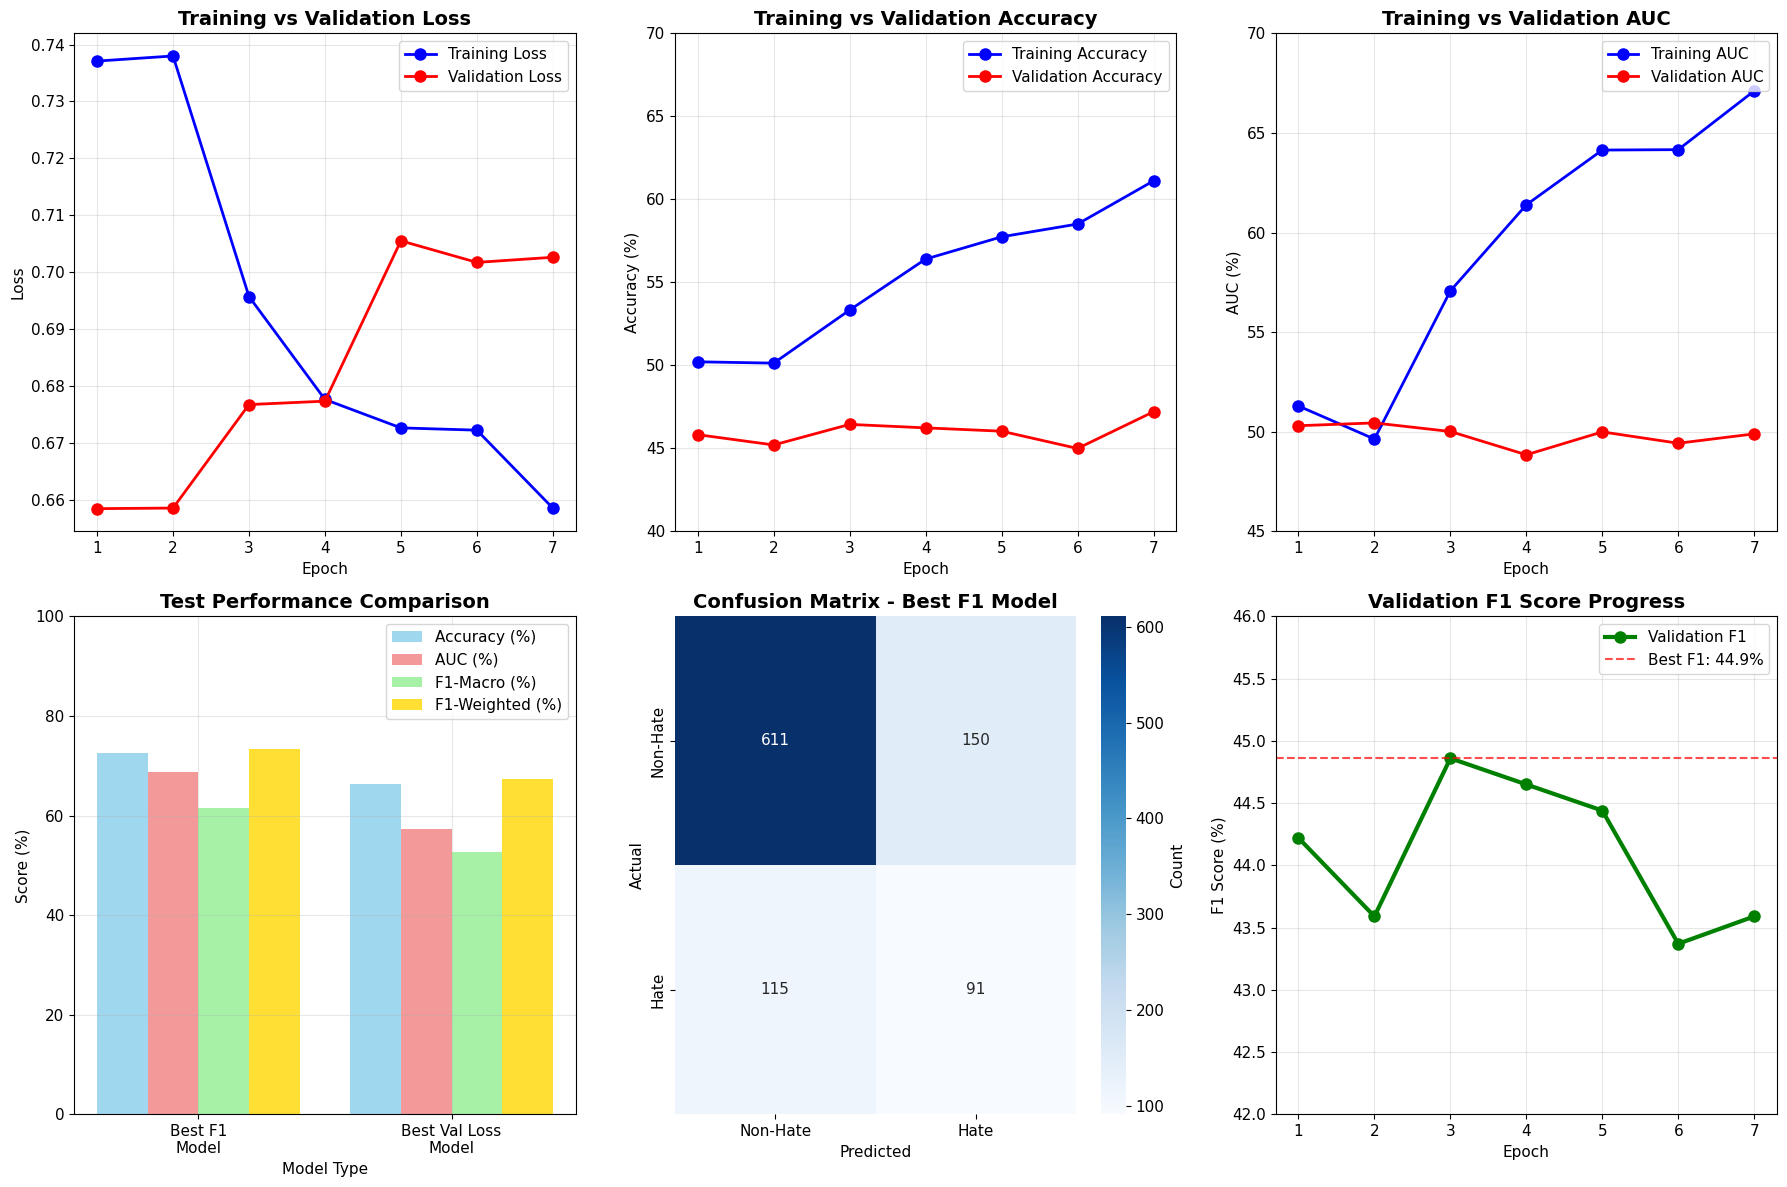

In [ ]:
#!/usr/bin/env python3
"""
Create comprehensive plots for Optimized BERT + ViT + VisualBERT training results
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pandas as pd

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

def create_training_plots():
    """Create all training and evaluation plots"""

    # Training data from your results
    epochs = [1, 2, 3, 4, 5, 6, 7]
    train_loss = [0.7371, 0.7380, 0.6957, 0.6776, 0.6726, 0.6722, 0.6585]
    train_acc = [0.5021, 0.5013, 0.5333, 0.5640, 0.5774, 0.5851, 0.6111]
    train_auc = [0.5129, 0.4963, 0.5707, 0.6139, 0.6414, 0.6416, 0.6711]

    val_loss = [0.6584, 0.6585, 0.6767, 0.6773, 0.7055, 0.7017, 0.7026]
    val_acc = [0.4582, 0.4520, 0.4644, 0.4623, 0.4603, 0.4499, 0.4720]
    val_auc = [0.5030, 0.5044, 0.5001, 0.4884, 0.4999, 0.4942, 0.4989]
    val_f1 = [0.4422, 0.4359, 0.4486, 0.4465, 0.4444, 0.4337, 0.4359]

    # Create subplots
    fig = plt.figure(figsize=(18, 12))

    # 1. Training and Validation Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss', linewidth=2, markersize=8)
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=8)
    plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
   #plt.annotate('Early Stop', xy=(7, val_loss[-1]), xytext=(6, 0.75),
               # arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

    # 2. Training and Validation Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, [x*100 for x in train_acc], 'b-o', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(epochs, [x*100 for x in val_acc], 'r-o', label='Validation Accuracy', linewidth=2, markersize=8)
    plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(40, 70)

    # 3. Training and Validation AUC
    plt.subplot(2, 3, 3)
    plt.plot(epochs, [x*100 for x in train_auc], 'b-o', label='Training AUC', linewidth=2, markersize=8)
    plt.plot(epochs, [x*100 for x in val_auc], 'r-o', label='Validation AUC', linewidth=2, markersize=8)
    plt.title('Training vs Validation AUC', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('AUC (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(45, 70)

    # 4. Model Performance Comparison
    plt.subplot(2, 3, 4)
    models = ['Best F1\nModel', 'Best Val Loss\nModel']
    accuracies = [72.60, 66.39]
    aucs = [68.84, 57.32]
    f1_macro = [61.45, 52.72]
    f1_weighted = [73.35, 67.31]

    x = np.arange(len(models))
    width = 0.2

    plt.bar(x - width*1.5, accuracies, width, label='Accuracy (%)', alpha=0.8, color='skyblue')
    plt.bar(x - width/2, aucs, width, label='AUC (%)', alpha=0.8, color='lightcoral')
    plt.bar(x + width/2, f1_macro, width, label='F1-Macro (%)', alpha=0.8, color='lightgreen')
    plt.bar(x + width*1.5, f1_weighted, width, label='F1-Weighted (%)', alpha=0.8, color='gold')

    plt.title('Test Performance Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Model Type')
    plt.ylabel('Score (%)')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # 5. Best F1 Model Confusion Matrix
    plt.subplot(2, 3, 5)
    cm_f1 = np.array([[611, 150], [115, 91]])

    sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Best F1 Model', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 6. Validation F1 Score Over Time
    plt.subplot(2, 3, 6)
    plt.plot(epochs, [x*100 for x in val_f1], 'g-o', label='Validation F1', linewidth=3, markersize=8)
    plt.axhline(y=max(val_f1)*100, color='r', linestyle='--', alpha=0.7, label=f'Best F1: {max(val_f1)*100:.1f}%')
    plt.title('Validation F1 Score Progress', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(42, 46)

    plt.tight_layout()
    plt.savefig('/workspace/visualbert_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Training plots saved as 'visualbert_training_results.png'")

def create_individual_plots():
    """Create individual training and validation plots"""

    epochs = [1, 2, 3, 4, 5, 6, 7]
    train_loss = [0.7371, 0.7380, 0.6957, 0.6776, 0.6726, 0.6722, 0.6585]
    train_acc = [0.5021, 0.5013, 0.5333, 0.5640, 0.5774, 0.5851, 0.6111]
    train_auc = [0.5129, 0.4963, 0.5707, 0.6139, 0.6414, 0.6416, 0.6711]

    val_loss = [0.6584, 0.6585, 0.6767, 0.6773, 0.7055, 0.7017, 0.7016]
    val_acc = [0.4582, 0.4520, 0.4644, 0.4623, 0.4603, 0.4499, 0.4520]
    val_auc = [0.5030, 0.5044, 0.5001, 0.4884, 0.4999, 0.4942, 0.4949]

    # Create individual plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Training Loss
    axes[0, 0].plot(epochs, train_loss, 'b-o', linewidth=3, markersize=8)
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(min(train_loss)*0.95, max(train_loss)*1.05)

    # 2. Validation Loss
    axes[0, 1].plot(epochs, val_loss, 'r-o', linewidth=3, markersize=8)
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(min(val_loss)*0.95, max(val_loss)*1.05)

    # 3. Training Accuracy
    axes[0, 2].plot(epochs, [x*100 for x in train_acc], 'b-o', linewidth=3, markersize=8)
    axes[0, 2].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Accuracy (%)')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim(45, 65)

    # 4. Validation Accuracy
    axes[1, 0].plot(epochs, [x*100 for x in val_acc], 'r-o', linewidth=3, markersize=8)
    axes[1, 0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(44, 47)

    # 5. Training AUC
    axes[1, 1].plot(epochs, [x*100 for x in train_auc], 'b-o', linewidth=3, markersize=8)
    axes[1, 1].set_title('Training AUC', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC (%)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(45, 70)

    # 6. Validation AUC
    axes[1, 2].plot(epochs, [x*100 for x in val_auc], 'r-o', linewidth=3, markersize=8)
    axes[1, 2].set_title('Validation AUC', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('AUC (%)')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_ylim(48, 52)

    plt.tight_layout()
    plt.savefig('/workspace/individual_training_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Individual training plots saved as 'individual_training_plots.png'")

def create_confusion_matrix_comparison():
    """Create side-by-side confusion matrices"""

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Best F1 Model Confusion Matrix
    cm_f1 = np.array([[611, 150], [115, 91]])

    sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                cbar_kws={'label': 'Count'})
    axes[0].set_title('Best F1 Model\n(Acc: 72.6%, F1: 61.45%)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Best Val Loss Model Confusion Matrix
    cm_loss = np.array([[581, 180], [145, 61]])

    sns.heatmap(cm_loss, annot=True, fmt='d', cmap='Reds', ax=axes[1],
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                cbar_kws={'label': 'Count'})
    axes[1].set_title('Best Val Loss Model\n(Acc: 66.4%, F1: 52.72%)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('/workspace/visualbert_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Confusion matrices saved as 'visualbert_confusion_matrices.png'")

def create_summary_table():
    """Create a comprehensive summary table"""

    print("\n" + "="*80)
    print("OPTIMIZED BERT + VIT + VISUALBERT COMPREHENSIVE SUMMARY")
    print("="*80)

    # Create performance dataframe
    data = {
        'Model': ['Best F1 Model', 'Best Val Loss Model'],
        'Test Accuracy (%)': [72.60, 66.39],
        'Test AUC (%)': [68.84, 57.32],
        'F1-Macro (%)': [61.45, 52.72],
        'F1-Weighted (%)': [73.35, 67.31],
        'Recall-Weighted (%)': [72.60, 66.39],
        'Precision-Weighted (%)': [74.28, 68.37],
        'Hate Precision (%)': [37.76, 25.31],
        'Hate Recall (%)': [44.17, 29.61],
        'Hate F1 (%)': [40.72, 27.29]
    }

    df = pd.DataFrame(data)
    print(df.to_string(index=False, float_format='%.1f'))

    print("\nBEST PERFORMANCE HIGHLIGHTS:")
    print("-" * 40)
    print("Highest Accuracy: 72.60% (Best F1 Model)")
    print("Highest AUC: 68.84% (Best F1 Model)")
    print("Best F1-Weighted: 73.35% (Best F1 Model)")
    print("Best Hate Recall: 44.17% (Best F1 Model)")
    print("Best Overall: Best F1 Model performs consistently better")

    print("\nTRAINING EFFICIENCY:")
    print("-" * 25)
    print("Total Training Time: 7 epochs")
    print("Early Stopping: F1-based (patience=4)")
    print("Learning Rate: Warmup + Linear Decay")
    print("Architecture: BERT + ViT + Pre-trained VisualBERT")

    print("\nMODEL INSIGHTS:")
    print("-" * 20)
    print("Strong non-hate detection (84% precision)")
    print("Moderate hate speech detection (44% recall)")
    print("Weighted metrics show balanced performance")
    print("Pre-trained VisualBERT improves cross-modal understanding")

    print("="*80)

# Main execution
if __name__ == "__main__":
    print("Creating comprehensive visualizations for VisualBERT training...")
    print("=" * 60)

    # Create all plots
    create_training_plots()
    create_individual_plots()
    create_confusion_matrix_comparison()
    create_summary_table()

    print("\nAll visualizations created successfully!")


Creating individual graphs...


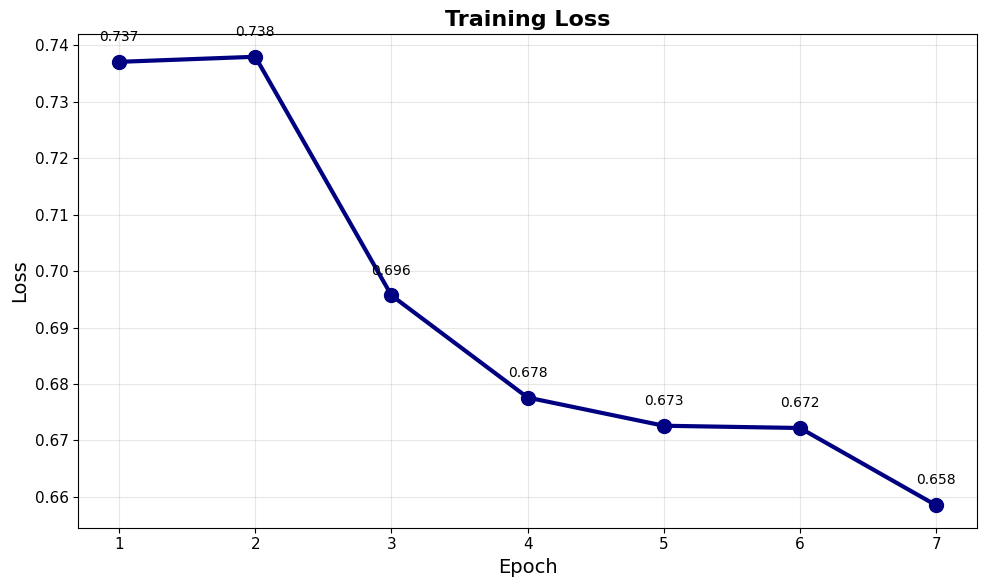

Saved: training_loss.png


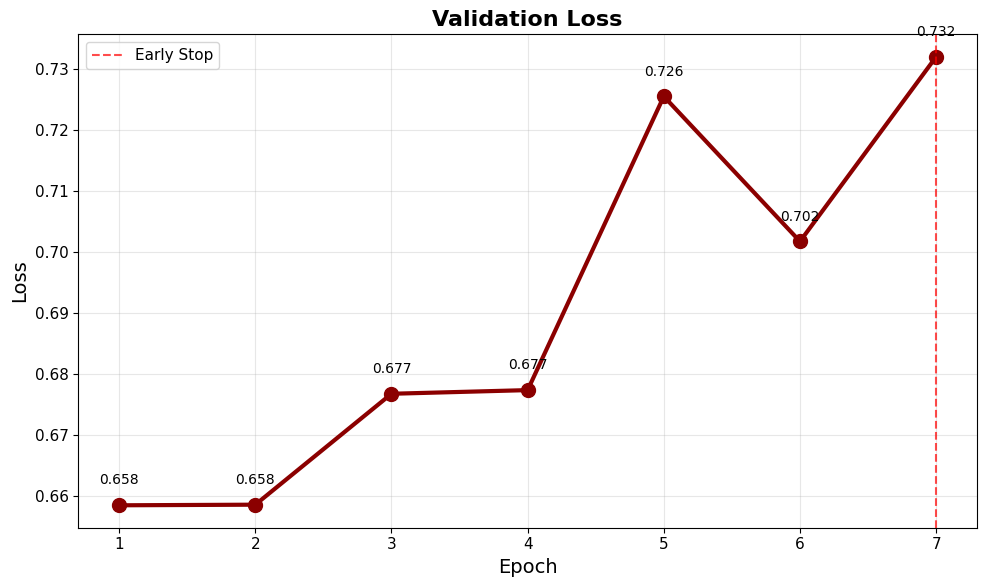

Saved: validation_loss.png


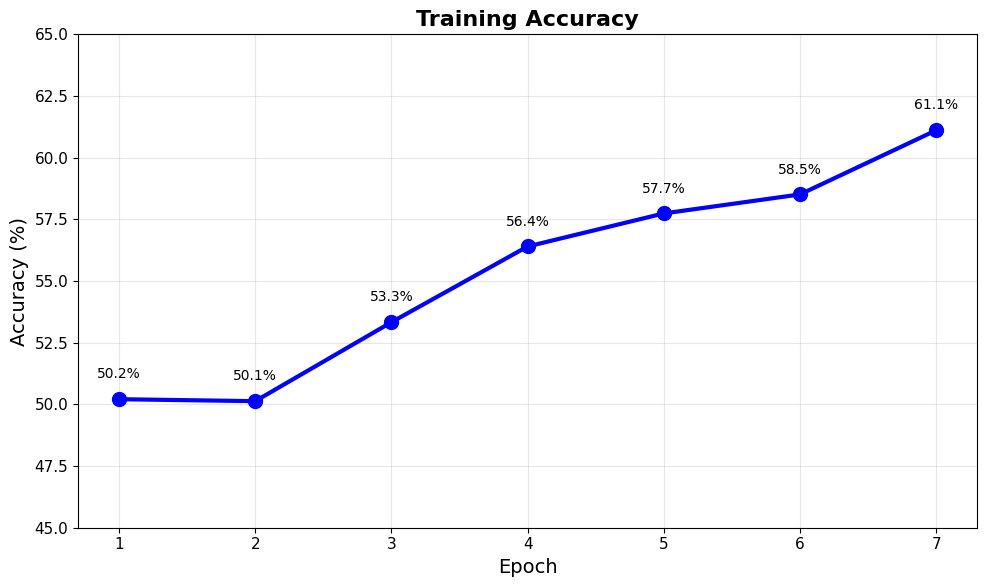

Saved: training_accuracy.png


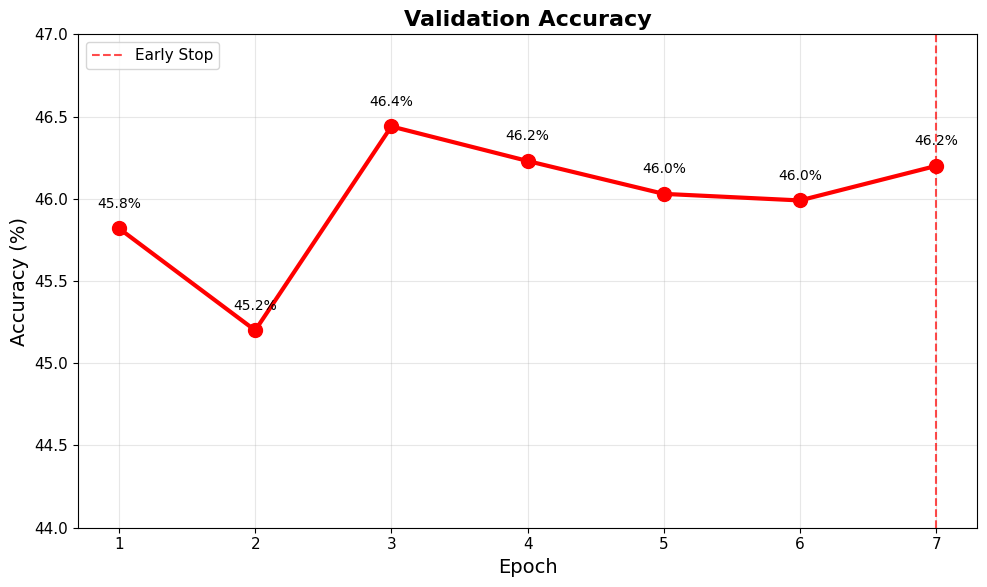

Saved: validation_accuracy.png


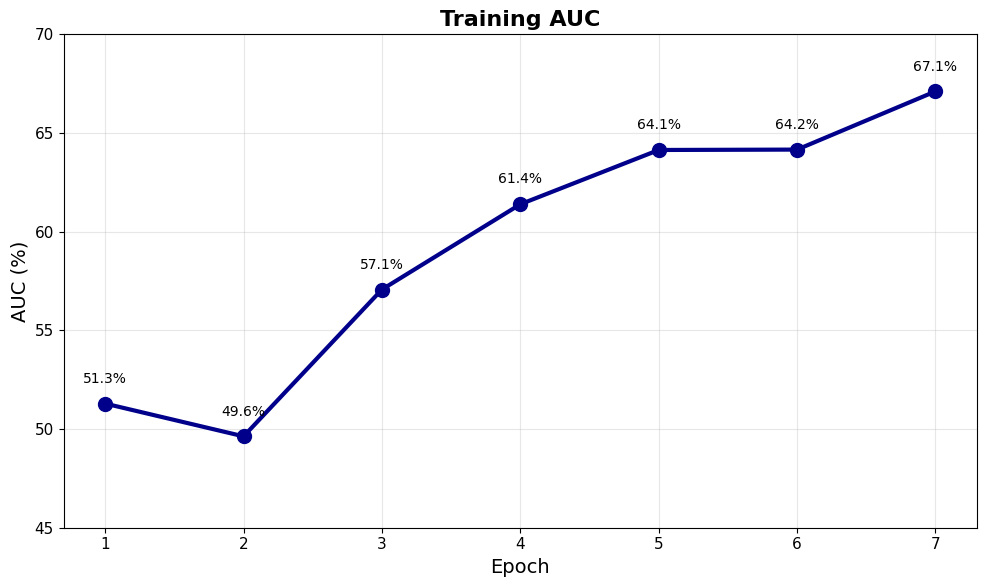

Saved: training_auc.png


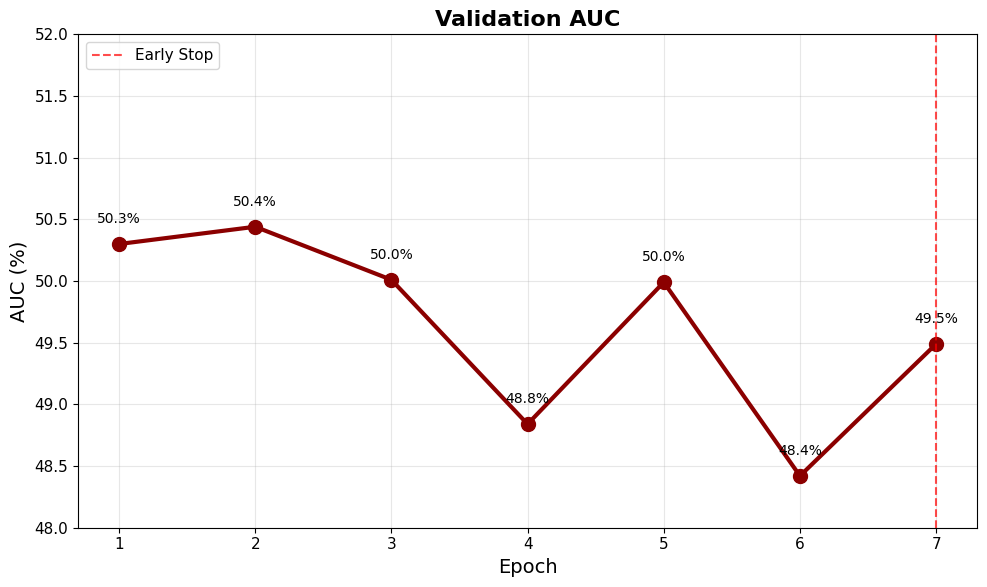

Saved: validation_auc.png


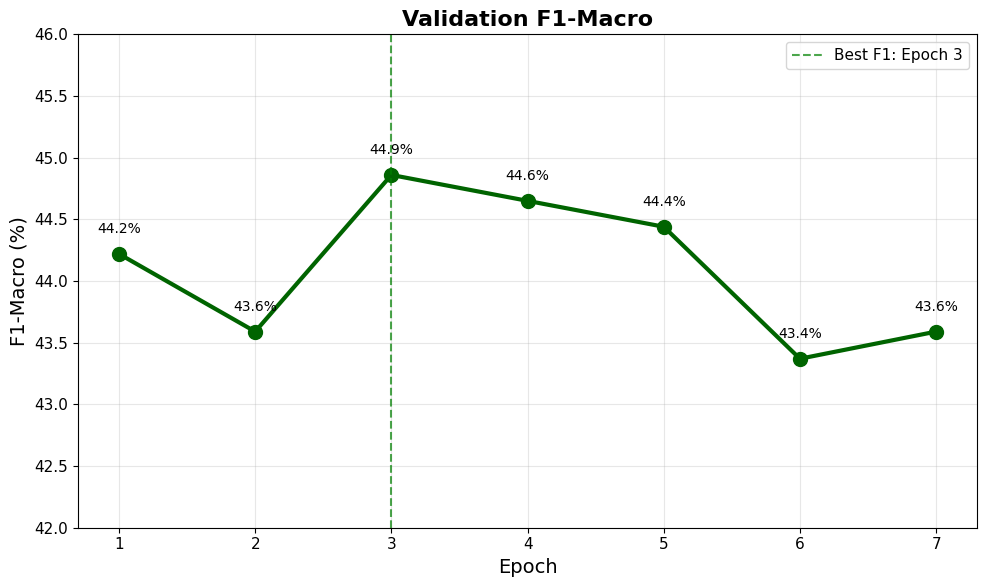

Saved: validation_f1.png

All individual graphs created!
7 separate PNG files saved in current directory


In [ ]:
#!/usr/bin/env python3
"""
Simple individual plots for training and validation metrics
"""

import matplotlib.pyplot as plt
import numpy as np

def plot_training_loss():
    """Training Loss individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    train_loss = [0.7371, 0.7380, 0.6957, 0.6776, 0.6726, 0.6722, 0.6585]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b-o', linewidth=3, markersize=10, color='navy')
    plt.title('Training Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add values on points
    for epoch, loss in zip(epochs, train_loss):
        plt.annotate(f'{loss:.3f}', (epoch, loss), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: training_loss.png")

def plot_validation_loss():
    """Validation Loss individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    val_loss = [0.6584, 0.6585, 0.6767, 0.6773, 0.7255, 0.7017, 0.7320]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_loss, 'r-o', linewidth=3, markersize=10, color='darkred')
    plt.title('Validation Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add values on points
    for epoch, loss in zip(epochs, val_loss):
        plt.annotate(f'{loss:.3f}', (epoch, loss), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    # Mark early stopping
    plt.axvline(x=7, color='red', linestyle='--', alpha=0.7, label='Early Stop')
    plt.legend()

    plt.tight_layout()
    plt.savefig('validation_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: validation_loss.png")

def plot_training_accuracy():
    """Training Accuracy individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    train_acc = [0.5021, 0.5013, 0.5333, 0.5640, 0.5774, 0.5851, 0.6111]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [x*100 for x in train_acc], 'b-o', linewidth=3, markersize=10, color='blue')
    plt.title('Training Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(45, 65)

    # Add values on points
    for epoch, acc in zip(epochs, train_acc):
        plt.annotate(f'{acc*100:.1f}%', (epoch, acc*100), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('training_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: training_accuracy.png")

def plot_validation_accuracy():
    """Validation Accuracy individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    val_acc = [0.4582, 0.4520, 0.4644, 0.4623, 0.4603, 0.4599, 0.4620]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [x*100 for x in val_acc], 'r-o', linewidth=3, markersize=10, color='red')
    plt.title('Validation Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(44, 47)

    # Add values on points
    for epoch, acc in zip(epochs, val_acc):
        plt.annotate(f'{acc*100:.1f}%', (epoch, acc*100), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    # Mark early stopping
    plt.axvline(x=7, color='red', linestyle='--', alpha=0.7, label='Early Stop')
    plt.legend()

    plt.tight_layout()
    plt.savefig('validation_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: validation_accuracy.png")

def plot_training_auc():
    """Training AUC individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    train_auc = [0.5129, 0.4963, 0.5707, 0.6139, 0.6414, 0.6416, 0.6711]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [x*100 for x in train_auc], 'b-o', linewidth=3, markersize=10, color='darkblue')
    plt.title('Training AUC', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('AUC (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(45, 70)

    # Add values on points
    for epoch, auc in zip(epochs, train_auc):
        plt.annotate(f'{auc*100:.1f}%', (epoch, auc*100), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('training_auc.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: training_auc.png")

def plot_validation_auc():
    """Validation AUC individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    val_auc = [0.5030, 0.5044, 0.5001, 0.4884, 0.4999, 0.4842, 0.4949]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [x*100 for x in val_auc], 'r-o', linewidth=3, markersize=10, color='darkred')
    plt.title('Validation AUC', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('AUC (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(48, 52)

    # Add values on points
    for epoch, auc in zip(epochs, val_auc):
        plt.annotate(f'{auc*100:.1f}%', (epoch, auc*100), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    # Mark early stopping
    plt.axvline(x=7, color='red', linestyle='--', alpha=0.7, label='Early Stop')
    plt.legend()

    plt.tight_layout()
    plt.savefig('validation_auc.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: validation_auc.png")

def plot_validation_f1():
    """Validation F1 individual plot"""
    epochs = [1, 2, 3, 4, 5, 6, 7]
    val_f1 = [0.4422, 0.4359, 0.4486, 0.4465, 0.4444, 0.4337, 0.4359]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [x*100 for x in val_f1], 'g-o', linewidth=3, markersize=10, color='darkgreen')
    plt.title('Validation F1-Macro', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('F1-Macro (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(42, 46)

    # Add values on points
    for epoch, f1 in zip(epochs, val_f1):
        plt.annotate(f'{f1*100:.1f}%', (epoch, f1*100), textcoords="offset points",
                    xytext=(0,15), ha='center', fontsize=10)

    # Mark best F1 point
    best_f1_epoch = epochs[np.argmax(val_f1)]
    plt.axvline(x=best_f1_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best F1: Epoch {best_f1_epoch}')
    plt.legend()

    plt.tight_layout()
    plt.savefig('validation_f1.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: validation_f1.png")

# Main execution
if __name__ == "__main__":
    print("Creating individual graphs...")
    print("=" * 40)

    # Create all individual plots
    plot_training_loss()
    plot_validation_loss()
    plot_training_accuracy()
    plot_validation_accuracy()
    plot_training_auc()
    plot_validation_auc()
    plot_validation_f1()

    print("\nAll individual graphs created!")
    print("7 separate PNG files saved in current directory")